In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


file_path = '/users/2/vargh085/Base.csv'

# Load the dataset using pandas
import pandas as pd
df = pd.read_csv(file_path)

df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [2]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [3]:
# Display data types
print(df.dtypes.value_counts())

# List of categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

from sklearn.model_selection import train_test_split

# Stratified sampling 
df_sampled, _ = train_test_split(df, train_size=500000, stratify=df['fraud_bool'], random_state=42)

# Reset index after sampling
df_sampled = df_sampled.reset_index(drop=True)

# Check the shape and class distribution
print("\nSampled DataFrame Shape:", df_sampled.shape)
print("Class Distribution in Sampled Data:")
print(df_sampled['fraud_bool'].value_counts(normalize=True))

int64      18
float64     9
object      5
dtype: int64
Categorical columns: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
Numerical columns: ['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

Sampled DataFrame Shape: (500000, 32)
Class Distribution in Sampled Data:
0    0.98897
1    0.01103
Name: fraud_bool, dtype: float64


In [4]:
# Get categorical columns directly from df_sampled to ensure they exist
categorical_cols_sampled = df_sampled.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns in Sampled Data:", categorical_cols_sampled)

# One-Hot Encoding with updated categorical columns
df_encoded = pd.get_dummies(df_sampled, columns=categorical_cols_sampled, drop_first=True)

# Update list of numerical columns after encoding
numerical_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('fraud_bool')  # Exclude target variable
print("\nNumerical Columns after Encoding:", numerical_cols)

# Check data types of all columns
print("\nData Types After Encoding:")
print(df_encoded.dtypes.value_counts())



Categorical Columns in Sampled Data: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

Numerical Columns after Encoding: ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

Data Types After Encoding:
uint8      21
int64      18
float64     9
dtype: int64


In [5]:
columns_to_transform = ['days_since_request', 'foreign_request','bank_branch_count_8w','has_other_cards','zip_count_4w', 'proposed_credit_limit']

# Apply natural logarithm transformation to specified columns
df_encoded[columns_to_transform] = np.log1p(df_encoded[columns_to_transform])

In [6]:
from sklearn.preprocessing import StandardScaler

# Features to scale (excluding the target variable)
features_to_scale = [col for col in df_encoded.columns if col != 'fraud_bool' and df_encoded[col].dtype != 'bool']

scaler = StandardScaler()
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# Combine features and target
X = df_encoded.drop('fraud_bool', axis=1)
y = df_encoded['fraud_bool']

# Split into training and test sets (with stratification)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# To handle imbalanced classes with SMOTE on the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_full, y_train_full)

# sm = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = sm.fit_resample(X_train_full, y_train_full)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train_full, y_train_full)

# 4. ADASYN
# ada = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = ada.fit_resample(X_train_full, y_train_full)

# Verify the class distribution
print("Class distribution after undersampling:")
# Directly apply value_counts() to the y_train_resampled Series
print(y_train_resampled.value_counts())

Class distribution after undersampling:
1    3861
0    3861
Name: fraud_bool, dtype: int64


In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20, random_state=42)
pca.fit(X_train_resampled)
X_train_pca = pca.transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

In [9]:
from sklearn.svm import SVC

# Initialize the SVM model with a linear kernel
svm_model = SVC(C=1,kernel='rbf',gamma='scale', probability=True, random_state=42)

# Train the model
svm_model.fit(X_train_pca, y_train_resampled)

KeyboardInterrupt: 


Chosen Threshold for ~5% FPR: 0.8208
Actual FPR at Chosen Threshold: 0.0500
Recall (TPR) at Chosen Threshold: 0.4637

Classification Report at 5% FPR Threshold:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    222518
           1       0.09      0.46      0.16      2482

    accuracy                           0.94    225000
   macro avg       0.54      0.71      0.56    225000
weighted avg       0.98      0.94      0.96    225000



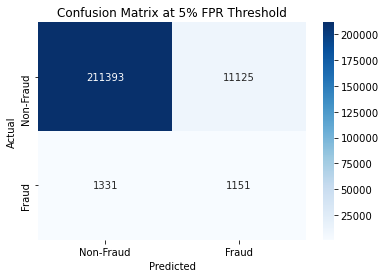

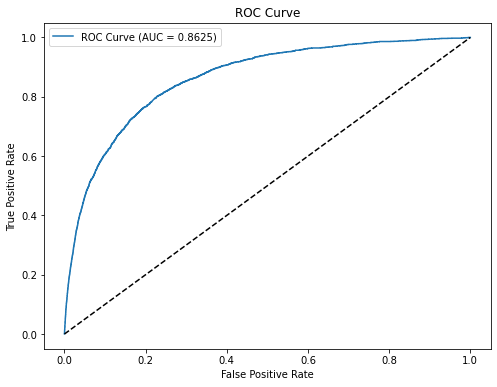

In [10]:
y_scores = svm_model.predict_proba(X_test_pca)[:, 1]
roc_auc = roc_auc_score(y_test, y_scores)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

target_fpr = 0.05
idx = np.argmin(np.abs(fpr - target_fpr))
chosen_threshold = thresholds[idx]
chosen_fpr = fpr[idx]
chosen_tpr = tpr[idx]

print(f"\nChosen Threshold for ~5% FPR: {chosen_threshold:.4f}")
print(f"Actual FPR at Chosen Threshold: {chosen_fpr:.4f}")
print(f"Recall (TPR) at Chosen Threshold: {chosen_tpr:.4f}")

y_pred_5fpr = (y_scores >= chosen_threshold).astype(int)

print("\nClassification Report at 5% FPR Threshold:")
print(classification_report(y_test, y_pred_5fpr))

cm = confusion_matrix(y_test, y_pred_5fpr)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix at 5% FPR Threshold')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'gamma': ['scale', 'auto']
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the SVM classifier without specifying hyperparameters
svm = SVC(probability=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='roc_auc',            # Evaluation metric
    cv=cv,
    n_jobs=-1,                    # Utilize all available cores
    verbose=2,                    # For detailed logs
    return_train_score=True       # To access training scores
)

# Fit GridSearchCV to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'sigmoid', 'poly']},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [12]:
# Best hyperparameters found by GridSearchCV
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Best ROC-AUC score achieved during cross-validation
print(f"\nBest ROC-AUC Score during CV: {grid_search.best_score_:.4f}")

# Access the best estimator
best_svm = grid_search.best_estimator_


Best Hyperparameters:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Best ROC-AUC Score during CV: 0.8687


In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'gamma': ['scale', 'auto']
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the SVM classifier without specifying hyperparameters
svm = SVC(probability=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='roc_auc',            # Evaluation metric
    cv=cv,
    n_jobs=-1,                    # Utilize all available cores
    verbose=2,                    # For detailed logs
    return_train_score=True       # To access training scores
)

# Fit GridSearchCV to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'sigmoid', 'poly']},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [15]:
results = pd.DataFrame(grid_search.cv_results_)
# Filter results by kernel and print their mean AUC for comparison
for k in ['linear', 'rbf', 'poly','sigmoid']:
    mean_score = results[results['param_kernel'] == k]['mean_test_score'].max()
    print(f"Best AUC for {k} kernel: {mean_score:.4f}")


Best AUC for linear kernel: 0.8778
Best AUC for rbf kernel: 0.8782
Best AUC for poly kernel: 0.8646
Best AUC for sigmoid kernel: 0.8719


In [12]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['poly'],
    'gamma': ['scale'],
    'degree': [4,5,6]
    
}


from sklearn.metrics import make_scorer, roc_auc_score, recall_score, precision_score, f1_score

# Define scoring metrics as a dictionary
scoring = {
    'roc_auc': 'roc_auc',  # Using a built-in metric
    'recall': make_scorer(recall_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',   # The metric to refit on (usually the main metric)
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train_resampled, y_train_resampled)

results = pd.DataFrame(grid_search.cv_results_)

# Print best AUC, Recall, Precision, and F1 for each kernel
for k in [4,5,6]:
    subset = results[results['param_degree'] == k]
    best_auc = subset['mean_test_roc_auc'].max()
    best_recall = subset['mean_test_recall'].max()
    best_precision = subset['mean_test_precision'].max()
    best_f1 = subset['mean_test_f1'].max()
    print(f"\ndegree: {k}")
    print(f"Best AUC: {best_auc:.4f}")
    print(f"Best Recall: {best_recall:.4f}")
    print(f"Best Precision: {best_precision:.4f}")
    print(f"Best F1: {best_f1:.4f}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits

degree: 4
Best AUC: 0.8268
Best Recall: 0.6887
Best Precision: 0.8612
Best F1: 0.7254

degree: 5
Best AUC: 0.8269
Best Recall: 0.6607
Best Precision: 0.8689
Best F1: 0.7229

degree: 6
Best AUC: 0.8110
Best Recall: 0.5657
Best Precision: 0.8363
Best F1: 0.6648


In [10]:
from sklearn.metrics import make_scorer, roc_auc_score, recall_score, precision_score, f1_score

# Define scoring metrics as a dictionary
scoring = {
    'roc_auc': 'roc_auc',  # Using a built-in metric
    'recall': make_scorer(recall_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',   # The metric to refit on (usually the main metric)
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train_resampled, y_train_resampled)

results = pd.DataFrame(grid_search.cv_results_)

# Print best AUC, Recall, Precision, and F1 for each kernel
for k in ['linear', 'rbf', 'poly', 'sigmoid']:
    subset = results[results['param_kernel'] == k]
    best_auc = subset['mean_test_roc_auc'].max()
    best_recall = subset['mean_test_recall'].max()
    best_precision = subset['mean_test_precision'].max()
    best_f1 = subset['mean_test_f1'].max()
    print(f"\nKernel: {k}")
    print(f"Best AUC: {best_auc:.4f}")
    print(f"Best Recall: {best_recall:.4f}")
    print(f"Best Precision: {best_precision:.4f}")
    print(f"Best F1: {best_f1:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Kernel: linear
Best AUC: 0.8714
Best Recall: 0.7757
Best Precision: 0.7967
Best F1: 0.7859

Kernel: rbf
Best AUC: 0.8669
Best Recall: 0.7845
Best Precision: 0.7901
Best F1: 0.7872

Kernel: poly
Best AUC: 0.8517
Best Recall: 0.7255
Best Precision: 0.8567
Best F1: 0.7569

Kernel: sigmoid
Best AUC: 0.8662
Best Recall: 0.7713
Best Precision: 0.7948
Best F1: 0.7828
